In [1]:
from lbmpy.session import *
from lbmpy.sparse import *
from pystencils.field import FieldType

import pystencils as ps

In [2]:
try:
    import cupy
except ImportError:
    cupy = None
    target = ps.Target.CPU
    print('No cupy installed')

if cupy:
    target = ps.Target.GPU

No cupy installed


# Sparse (list based) LBM

In [3]:
domain_size = (20, 20)
omega = 1.8
target = ps.Target.CPU

ghost_layers = 1
arr_size = tuple(ds + 2 * ghost_layers for ds in domain_size)
lid_velocity = 0.01
force = 1e-6

channel = True
if channel:
    lbm_config = LBMConfig(stencil=LBStencil(Stencil.D2Q9), relaxation_rate=omega,
                           compressible=False, force=(force, 0))
else:
    lbm_config = LBMConfig(stencil=LBStencil(Stencil.D2Q9), relaxation_rate=omega, compressible=False)
    

method = create_lb_method(lbm_config=lbm_config)

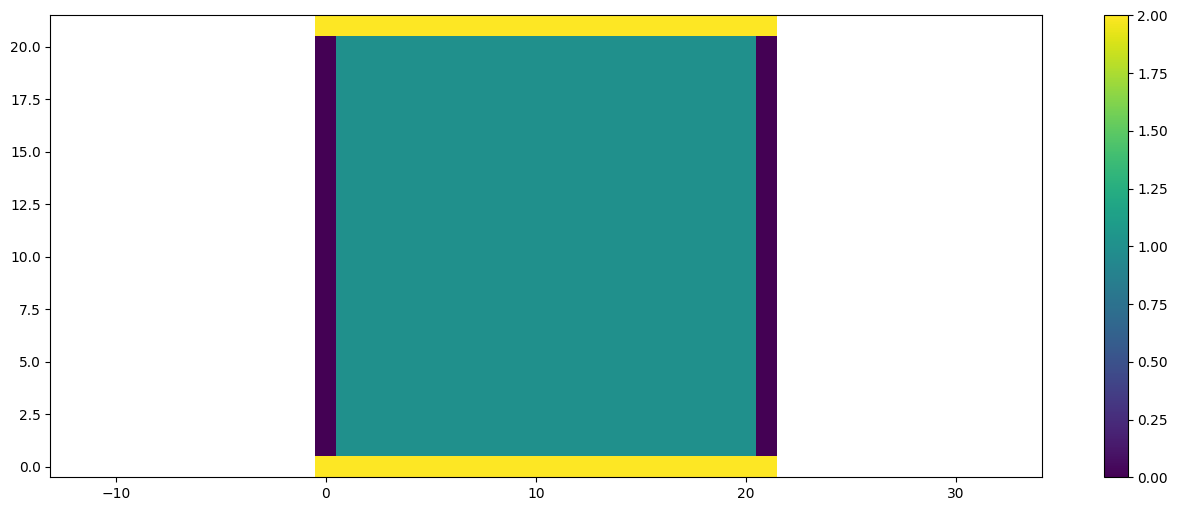

In [4]:
ubb = UBB( (lid_velocity, 0) )
noslip = NoSlip()
flags = {
    'fluid': 1, 
    noslip: 2,
    ubb: 4,
}
flag_arr = np.zeros(arr_size, dtype=np.uint16)
flag_arr.fill(flags['fluid'])

if channel:
    flag_arr[0, :] = 0
    flag_arr[-1, :] = 0   
    flag_arr[:, 0] = flags[noslip]
    flag_arr[:, -1] = flags[noslip]
else:
    flag_arr[:, -1] = flags[ubb]
    flag_arr[:, 0] = flags[noslip]
    flag_arr[0, :] = flags[noslip]
    flag_arr[-1, :] = flags[noslip]

plt.scalar_field(flag_arr)
plt.colorbar();

### Mappings

In [5]:
mapping = SparseLbMapper(method.stencil, flag_arr, flags['fluid'], flags[noslip], flags[ubb])
index_arr = mapping.create_index_array(ghost_layers)

# Arrays
#index_arr = index_arr_linear.reshape([len(method.stencil), mapping.num_fluid_cells])
#index_arr = index_arr.swapaxes(0, 1)

pdf_arr = np.empty((len(mapping), len(method.stencil)), order='f')
pdf_arr_tmp = np.empty_like(pdf_arr)

vel_arr = np.ones([mapping.num_fluid_cells, method.dim], order='f')

In [6]:
pdf_field, pdf_field_tmp, vel_field = ps.fields("f(9), d(9), u(2): [1D]",
                                                #f=pdf_arr[:mapping.num_fluid_cells],
                                                #d=pdf_arr_tmp[:mapping.num_fluid_cells],
                                                #u=vel_arr
                                               )
pdf_field.field_type = FieldType.CUSTOM
pdf_field.pdf_field_tmp = FieldType.CUSTOM

### Macroscopic quantities

In [7]:
cqc = method.conserved_quantity_computation
inp_eqs = cqc.equilibrium_input_equations_from_init_values(force_substitution=False)
setter_eqs = method.get_equilibrium(conserved_quantity_equations=inp_eqs)
setter_eqs = setter_eqs.new_with_substitutions({sym: pdf_field(i)
                                                for i, sym in enumerate(method.post_collision_pdf_symbols)})

config = ps.CreateKernelConfig(ghost_layers=((0, 0),))
kernel_initialize = ps.create_kernel(setter_eqs, config=config).compile()

def init():
    kernel_initialize(f=pdf_arr[:mapping.num_fluid_cells])
init()


getter_eqs = cqc.output_equations_from_pdfs(pdf_field.center_vector,
                                            {'velocity': vel_field})
kernel_compute_u = ps.create_kernel(getter_eqs, config=config).compile()

def get_velocity(arr=pdf_arr):
    fluid_cell_arr = mapping.coordinates
    kernel_compute_u(f=pdf_arr[:mapping.num_fluid_cells], u=vel_arr)
    full_velocity_arr = np.zeros(flag_arr.shape + (2,), dtype=np.float64)
    full_velocity_arr.fill(np.nan)
    arr = fluid_cell_arr[:mapping.num_fluid_cells]
    full_velocity_arr[arr['x'], arr['y']] = vel_arr
    return full_velocity_arr[1:-1, 1:-1]

### Stream Collide Kernel

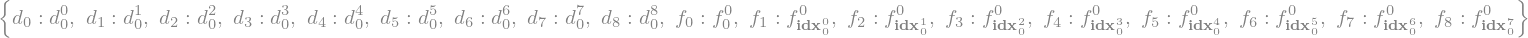

In [8]:
#index_field = ps.Field.create_from_numpy_array("idx", index_arr, index_dimensions=1)
index_field = ps.Field.create_generic("idx", spatial_dimensions=1, index_dimensions=1, dtype=index_arr.dtype)

collision_rule = method.get_collision_rule()

Q = len(method.stencil)
symbol_subs = {sym: pdf_field.absolute_access((index_field(i-1),),()) 
               for i, sym in enumerate(method.pre_collision_pdf_symbols)}

symbol_subs.update({sym: pdf_field_tmp(i) for i, sym in enumerate(method.post_collision_pdf_symbols)})

symbol_subs[method.pre_collision_pdf_symbols[0]] = pdf_field(0) # special case for center
symbol_subs

In [9]:
collision_rule = method.get_collision_rule()
update_rule = collision_rule.new_with_substitutions(symbol_subs)

config = ps.CreateKernelConfig(ghost_layers=((0, 0),), target=target)
kernel_stream_collide = ps.create_kernel(update_rule, config=config).compile()

### Boundary Kernels

In [10]:
if not channel:
    if target == ps.Target.GPU:
        raise NotImplementedError("UBB on GPU not working yet")
        
    ubb_mapper = SparseLbBoundaryMapper(ubb, method, pdf_field)
    #TODO the following line is wrong: kernel contains accesses to index_field and pdf_field which have 
    #different size: a correct kernel comes out when by change the shape is taken from index field, 
    # when taken from pdf field, a wrong kernel is generated
    ubb_kernel = ps.create_kernel(ubb_mapper.assignments(), ghost_layers=0).compile()
    ubb_idx_arr = ubb_mapper.create_index_arr(mapping, flags[ubb])
    ps.show_code(ubb_kernel.ast)
    def handle_ubb():
        ubb_kernel(indexField=ubb_idx_arr, f=pdf_arr[:mapping.num_fluid_cells])
else:
    def handle_ubb():
        pass

### Time Loop

In [11]:
def time_step():
    global pdf_arr, pdf_arr_tmp, index_arr
    handle_ubb()
    if target == ps.Target.GPU:
        gpu_pdf_arr = cupy.asarray(pdf_arr)
        gpu_pdf_arr_tmp = cupy.asarray(pdf_arr_tmp)
        gpu_index_arr = cupy.asarray(index_arr)
        
        kernel_stream_collide(f=gpu_pdf_arr[:mapping.num_fluid_cells], 
                          d=gpu_pdf_arr_tmp[:mapping.num_fluid_cells], 
                          idx=gpu_index_arr)
    
        pdf_arr[:] = gpu_pdf_arr.get()
        pdf_arr_tmp[:] = gpu_pdf_arr_tmp.get()
        index_arr[:] = gpu_index_arr.get()
    else:
        kernel_stream_collide(f=pdf_arr[:mapping.num_fluid_cells], 
                              d=pdf_arr_tmp[:mapping.num_fluid_cells], 
                              idx=index_arr)
    pdf_arr_tmp, pdf_arr = pdf_arr, pdf_arr_tmp

def run(steps=100):
    for t in range(steps):
        time_step()
    return get_velocity()

In [12]:
init()

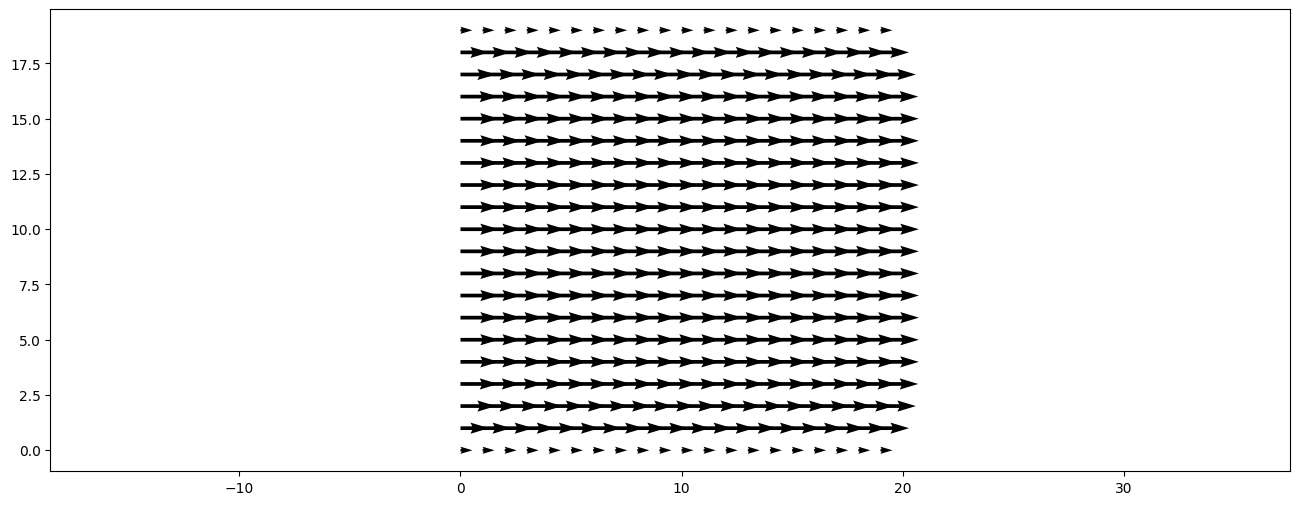

In [13]:
init()
result = run(100)
plt.vector_field(result, step=1);

### Check against reference

In [14]:
if channel:
    reference = create_channel(domain_size, force=force, lb_method=method)
else:
    reference = create_lid_driven_cavity(domain_size, relaxation_rate=omega, lid_velocity=lid_velocity,
                                         compressible=False)
reference.run(100)

In [15]:
np.testing.assert_almost_equal(reference.velocity[:, :], result)